# 2022/01/04/TUE

> ### ***`F1 스코어`***
     - 정밀도와 재현율이 어느 한 쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가진다.

### $F1 = 2 * \frac{precision   *   recall}{precision + recall}$

##### API : f1_score()

(168~169p 코드 참고)

---

> ### ***`ROC 곡선과 AUC 스코어`***
    - 이진 분류의 예측 성능 측정에서 중요하게 사용됨

ROC 곡선은 FPR을 0부터 1까지 변경하면서 TPR의 변화 값을 구함.  분류 결정 임계값을 변경하면 FPR을 0부터 1까지 변경할 수 있음. FPR을 0으로 만드려면 임계값을 1로 지정하면 된다. 

##### API : roc_curve()

171~172,174p 참고

- 일반적으로 ROC 곡선 자체는 FPR과 TPR의 변화값을 보는 데 이용하며 분류의 성능 지표로 사용되는 것을 ROC 곡선 면적에 기반한 AUC 값으로 결정한다. AUC가 1에 가까울수록 좋은 수치이다. AUC 수치가 커지려면 FPR이 작은 상태에서 얼마나 더 큰 TPR을 얻을 수 있느냐가 관건이다. 

__________________________

> ### ***`피마 인디언 당뇨병 예측`***

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
diabetes_data = pd.read_csv('diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


- Negative : 500, Positive : 268

In [4]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


- null값 없고, feature타입은 모두 숫자형
- 따라서 별도의 feature incoding은 불필요

#### ***`로지스틱 회귀를 이용해 예측 모델을 생성해보자`***

```python
# feature 데이터 세트 X, 레이블 데이터 세트 y를 추출
# 맨 끝이 Outcome 칼럼으로서 레이블 값임. 따라서 그 칼럼의 위치인 -1을 이용해 빼줌
X=diabetes_data.iloc[:,:-1] # feature 데이터 세트
y=diabetes_data.iloc[:,-1] # 레이블 데이터 세트

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state = 156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba=lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)
```

재현율 : 59.26%, 전체 데이터의 65%가Negative이므로 정확도보다는 재현율 성능에 조금 더 초점을 맞추기 위해 임곗값별 정밀도와 재현율 값의 변화를 확인해보자

```python
pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]
precision_recall_curve_plot(y_test,pred_proba_c1)
```

임계값 0.42 정도에서 정밀도와 재현율이 어느 정도 균형을 맞춤. 그렇지만 두 지표 모두 0.7이 안 되는 수치로서 아직도 낮은 지표 값임. 임계값을 임의적으로 조정하기 전에 데이터값을 다시 보자

In [6]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


min행이 0이 굉장히 많음. 예를 들어 Glucose는 포도당 수치인데 0인 것은 말이 안 됨.

(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <BarContainer object of 10 artists>)

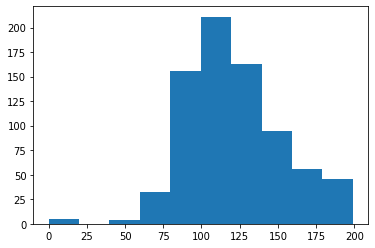

In [7]:
plt.hist(diabetes_data['Glucose'],bins=10)

0 값이 일정 수준 존재함을 알 수 있다.

min() 값이 0으로 돼 있는 feature에 대해 0 값의 건수 및 전체 데이터 건수 대비 및 몇 퍼센트의 비율로 존재하는지 확인해보자.

In [10]:
# 0값을 검사할 feature명 
zero_features=['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

# 전체 데이터 건수
total_count=diabetes_data['Glucose'].count()

#feature별로 반복하면서 데이터 값이 0인 데이터 건수를 추출하고, 퍼센트 계산해보자
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature]==0][feature].count()
    print('{} 0건수는 {}, 퍼센트는 {:.2f}%'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0건수는 5, 퍼센트는 0.65%
BloodPressure 0건수는 35, 퍼센트는 4.56%
SkinThickness 0건수는 227, 퍼센트는 29.56%
Insulin 0건수는 374, 퍼센트는 48.70%
BMI 0건수는 11, 퍼센트는 1.43%


- SkimThickness와 Insulin의 0 값은 각각 전체의 약 30,50%로 대단히 많다. 전체 데이터 건수가 약 800개 이므로 많지 않음, 따라서 0 데이터를 일괄적으로 삭제할 경우에는 학습을 효과적으로 수행하기 어렵다. 따라서 위 feature의 0값을 평균으로 대체해보자

In [12]:
# zero_features 리스트 내부에 저장된 개별 feature들에 대해서 0값을 평균값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features]=diabetes_data[zero_features].replace(0,mean_zero_features)

로지스틱 회귀의 경우 일반적으로 숫자 데이터에 스케일링을 적용하는 것이 좋음. 따라서 0값을 평균값으로 대체한 데이터 세트에 feature 스케일링을 적용해 변환해보자

```python
X=diabetes_data.iloc[:,:-1]
y=diabetes_data.iloc[:,-1]

# StandardScaler 클래스를 이용해 feature 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train,X_test,y_train,y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=156,stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf=LogisticRegression()
lr_clf.fit(X_train,y_train)
pred = lr_clf.predict(X_test)
pred_proba=lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test,pred,pred_proba)
```

데이터 변환과 스케일링을 통해 성능 수치가 일정 수준 개선됐지만 재현율 수치는 아직 개선이 더 필요, 분류  결정 임계값을 0.3에서 0.5까지 0.03씩 변화시키면서 재현율과 다른 평가 지표의 값 변화를 출력해보자

```python
thresholds = [0.3,0.33,0.36,0.39,0.42,0.45,0.5]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1),thresholds)
```

값을 반환했을 때 정확도와 정밀도를 어느 정도 희생하고 재현율을 높이는 데 가장 좋은 임계값은 0.33으로 재현율 값이 0.7963이다. 하지만 정밀도가 매우 저조해져서 극단적 선택임. 임계값 0.48이 전체적인 성능 평가 지표를 유지하면서 재현율을 약간 향상시키는 좋은 임계값으로 보임.

181p 코드 참고

> ####  지금까지 분류에 사용되는 정확도, 오차 행렬, 정밀도, 재현율, F1 스코어, ROC-AUC와 같은 성능 평가 지표가 있었음.